# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import datetime as dt
import statsmodels.api as sm

# Importation des données dans la variable data

In [2]:
data = pd.read_csv("Data/operations.csv")

# Vérifions d'abord les types des variables

In [3]:
data.dtypes

date_operation     object
libelle            object
montant           float64
solde_avt_ope     float64
categ              object
dtype: object

# La colonne *date_operation* ne semble pas avoir le bon type, réglons cela

In [16]:
data['date_operation']=pd.to_datetime(data['date_operation'])

# Vérifions s'il y a des valeurs manquantes

In [4]:
print(data.isnull().sum())

date_operation    0
libelle           0
montant           2
solde_avt_ope     0
categ             1
dtype: int64


# Regardons quelles sont les valeurs manquantes

In [5]:
print(data.loc[data['montant'].isnull(),:])

    date_operation                              libelle  montant  \
107     2023-06-12  CARTE XX XX LES ANCIENS ROBINSON XX      NaN   
269     2023-09-11                    CARTE XX XX XX XX      NaN   

     solde_avt_ope    categ  
107        4667.19  COURSES  
269        3401.93    AUTRE  


# Il manque 2 montants, les opérations étant dans l'ordre croissant, on peut calculer les valeurs manquantes
# Stockons les deux lignes dans la variable 'missing_montants'

In [6]:
missing_montants = data.loc[data['montant'].isnull(),:]

# Calculons les montants manquants à partir de la colonne 'solde_avt_ope'

In [7]:
for index in missing_montants.index :
    data.loc[index,'montant'] = data.loc[index+1,'solde_avt_ope'] - data.loc[index,'solde_avt_ope']

# Regardons maintenant la valeur manquante de la colonne 'categ'

In [8]:
print(data.loc[data['categ'].isnull(),:])

    date_operation                         libelle  montant  solde_avt_ope  \
156     2023-07-06  PRELEVEMENT XX TELEPHONE XX XX   -36.48        3295.68   

    categ  
156   NaN  


# Regardons les autres opérations ayant le même libellé 

In [9]:
print(data.loc[data['libelle'] == 'PRELEVEMENT XX TELEPHONE XX XX',:])

    date_operation                         libelle  montant  solde_avt_ope  \
8       2023-04-05  PRELEVEMENT XX TELEPHONE XX XX    -7.02        2056.02   
62      2023-05-09  PRELEVEMENT XX TELEPHONE XX XX    -7.02        4090.10   
102     2023-06-07  PRELEVEMENT XX TELEPHONE XX XX    -6.38        4688.91   
156     2023-07-06  PRELEVEMENT XX TELEPHONE XX XX   -36.48        3295.68   
204     2023-08-07  PRELEVEMENT XX TELEPHONE XX XX    -7.46        3751.73   
260     2023-09-05  PRELEVEMENT XX TELEPHONE XX XX    -6.38        3453.96   
308     2023-10-06  PRELEVEMENT XX TELEPHONE XX XX   -13.58        2413.58   

                 categ  
8    FACTURE TELEPHONE  
62   FACTURE TELEPHONE  
102  FACTURE TELEPHONE  
156                NaN  
204  FACTURE TELEPHONE  
260  FACTURE TELEPHONE  
308  FACTURE TELEPHONE  


# Toutes les opérations appartiennent à la même catégorie, il est donc raisonnable de penser que l'opération appartient à cette catégorie également

In [10]:
data.loc[data['libelle'] == 'PRELEVEMENT XX TELEPHONE XX XX','categ'] = 'FACTURE TELEPHONE'

# Les valeurs manquantes étant traitées, regardons s'il y a des doublons

In [11]:
print(data.loc[data.duplicated(keep=False),:])

   date_operation                              libelle  montant  \
43     2023-04-25  CARTE XX XX LES ANCIENS ROBINSON XX   -32.67   
44     2023-04-25  CARTE XX XX LES ANCIENS ROBINSON XX   -32.67   

    solde_avt_ope    categ  
43        3647.67  COURSES  
44        3647.67  COURSES  


# Les deux lignes sont complètement identiques, on peut en supprimer une

In [12]:
data.drop_duplicates(subset=['date_operation', 'libelle', 'montant', 'solde_avt_ope'], inplace=True, ignore_index=True)

# Regardons s'il y a des valeurs exceptionnelles

In [13]:
data.describe()

,montant,solde_avt_ope
count,308.000000,308.000000
mean,-45.782013,3395.301071
std,872.818105,667.109412
min,-15000.000000,1416.810000
25%,-20.447500,3010.737500
50%,-9.600000,3452.465000
75%,-2.715000,3787.232500
max,1071.600000,4709.310000


# Une valeur de -15000 semble excessive, allons voir de plus près

In [14]:
i = data.loc[data['montant'] == -15000,:].index[0] #On récupère l'indice de l'opération
print(data.iloc[i-1:i+2,:]) #On regarde l'opération d'avant et celle d'après

    date_operation                                       libelle   montant  \
197     2023-08-03  VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX    676.00   
198     2023-08-03                             CARTE XX XX XX XX -15000.00   
199     2023-08-03           CARTE XX XX L'EPICERIE DEMBAS XX XX    -10.51   

     solde_avt_ope  categ  
197        3121.35  AUTRE  
198        3797.35  AUTRE  
199        3782.96  AUTRE  


# Le montant semble démesuré lorsque l'on regarde la colonne 'solde_avt_ope'
# Recalculons tout ça

In [15]:
data.loc[data['montant'] == -15000,'montant'] = data.iloc[i+1,3] - data.iloc[i,3] #On recalcule le montant de l'opération
print(data.iloc[i,:])

date_operation           2023-08-03
libelle           CARTE XX XX XX XX
montant                      -14.39
solde_avt_ope               3797.35
categ                         AUTRE
Name: 198, dtype: object


<Axes: ylabel='proportion'>

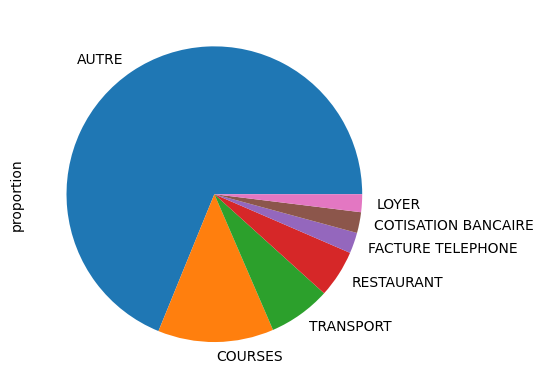

In [18]:
data['categ'].value_counts(normalize=True).plot(kind='pie') #Diagramme circulaire

# Créons une variable 'quart_mois' qui prend les valeurs 1,2,3 ou 4 selon la date à laquelle la transaction a été effectuée
### Par exemple, une opération ayant été faite le 5 du mois prendra la valeur 1

In [17]:
data['quart_mois'] = [int((jour-1)*4/31)+1 for jour in data["date_operation"].dt.day]


### On peut regarder quand est-ce que se font le plus souvent les opérations avec un diagramme en bâtons.

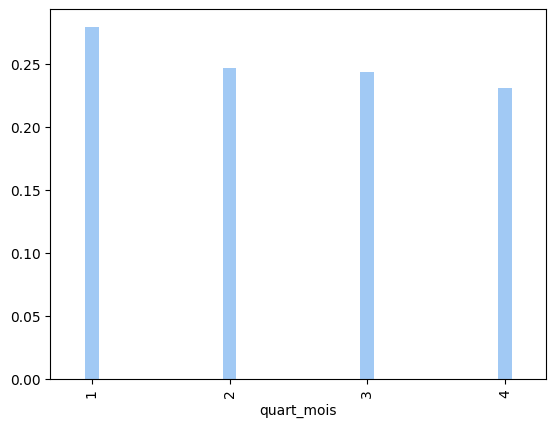

In [39]:
# Diagramme en bâtons
data["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

In [ ]:
# Créons un histogramme comptant les dépenses, elles sont regroupées en classes.

9


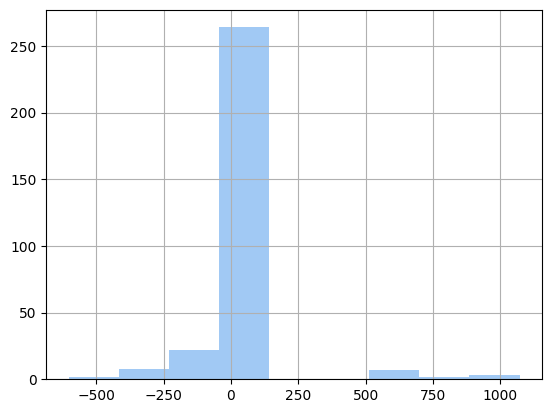

In [40]:
N = data.shape[0]
classes = int(1 + math.log2(N)) #Permet de calculer le nombre d'intervalles optimal
print(classes)
data['montant'].hist(bins=classes)
plt.show()

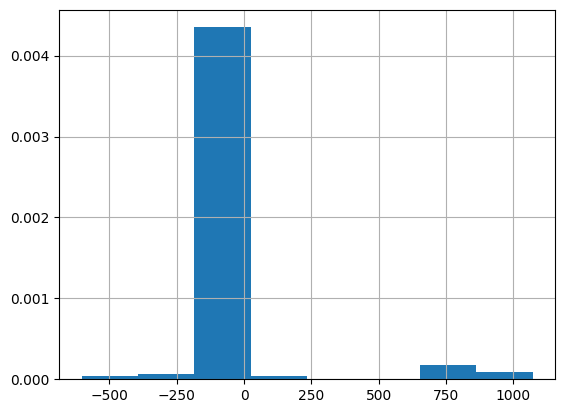

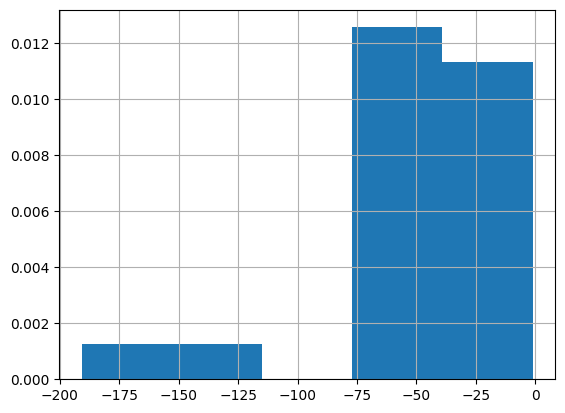

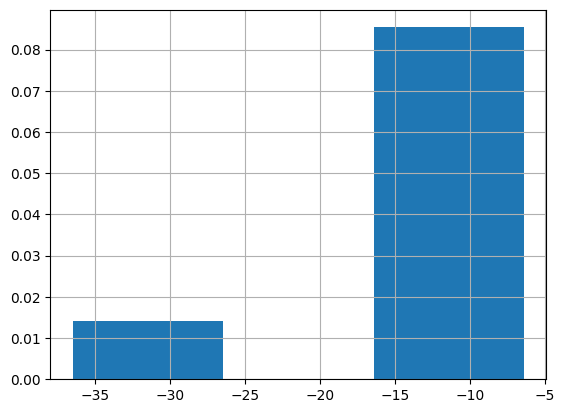

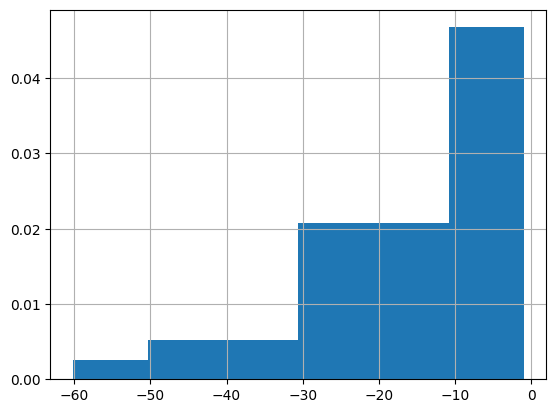

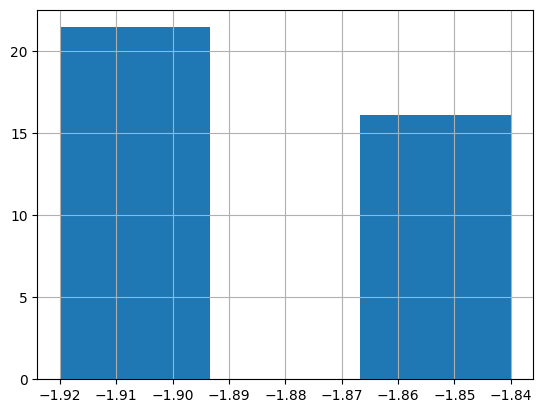

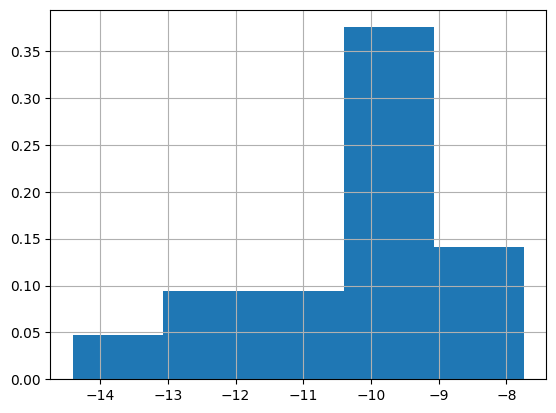

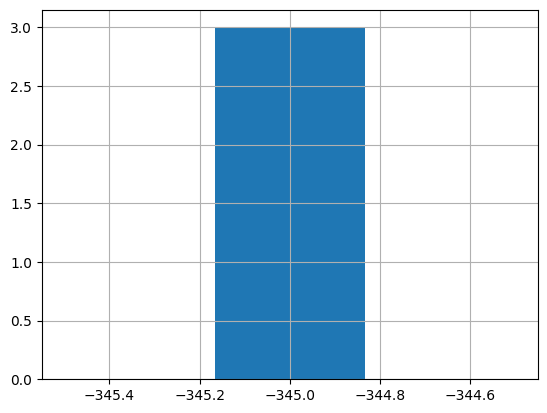

                 categ  Moyenne  Mediane   Mode  Variance  Ecart-Type  \
0                AUTRE     23.0     -8.0   -1.0   40593.0       201.0   
1            TRANSPORT    -52.0    -53.0  -73.0    2315.0        48.0   
2    FACTURE TELEPHONE    -12.0     -7.0   -7.0     122.0        11.0   
3              COURSES    -16.0    -12.0  -60.0     181.0        13.0   
4  COTISATION BANCAIRE     -1.0     -1.0   -1.0       0.0         0.0   
5           RESTAURANT    -10.0    -10.0   -9.0       3.0         1.0   
6                LOYER   -345.0   -345.0 -345.0       0.0         0.0   

   Skewness  Kurtosis  
0       3.0      12.0  
1      -1.0       2.0  
2      -2.0       5.0  
3      -1.0       1.0  
4       0.0      -2.0  
5       0.0       0.0  
6       0.0       0.0  


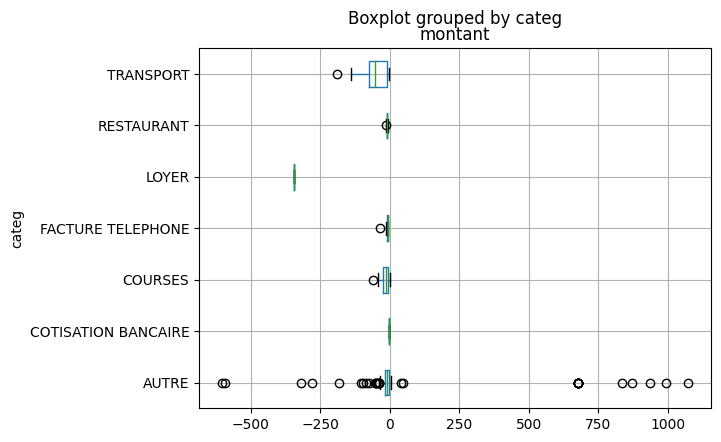

In [20]:
categorie = data['categ']
categorie.drop_duplicates(inplace=True, ignore_index=True)
tab = pd.DataFrame(categorie,index=None)

for categ in categorie :
    taille = data.loc[data['categ']==categ,'montant'].shape[0]
    tab.loc[tab['categ']== categ,'Moyenne'] = int(data.loc[data['categ']==categ,'montant'].mean())
    tab.loc[tab['categ']== categ,'Mediane'] = int(data.loc[data['categ']==categ,'montant'].median())
    tab.loc[tab['categ']== categ,'Mode'] = int(data.loc[data['categ']==categ,'montant'].mode()[0])
    tab.loc[tab['categ']== categ,'Variance'] = int(data.loc[data['categ']==categ,'montant'].var(ddof=1))
    tab.loc[tab['categ']== categ,'Ecart-Type'] = int(data.loc[data['categ']==categ,'montant'].std())
    tab.loc[tab['categ']== categ,'Skewness'] = int(data.loc[data['categ']==categ,'montant'].skew())
    tab.loc[tab['categ']== categ,'Kurtosis'] = int(data.loc[data['categ']==categ,'montant'].kurtosis())
    data.loc[data['categ']==categ,'montant'].hist(density=True,bins=int(1+math.log2(taille)))
    plt.show()
data.boxplot(column='montant', by='categ',vert=False)
print(tab)

# La dernière colonne ne prend que la première valeur apparue dans le dataframe si la distribution est plurimodale

In [21]:
print(data.loc[data['categ'] == 'COURSES','montant'].mode())

0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
Name: montant, dtype: float64


# Courbe de Lorenz

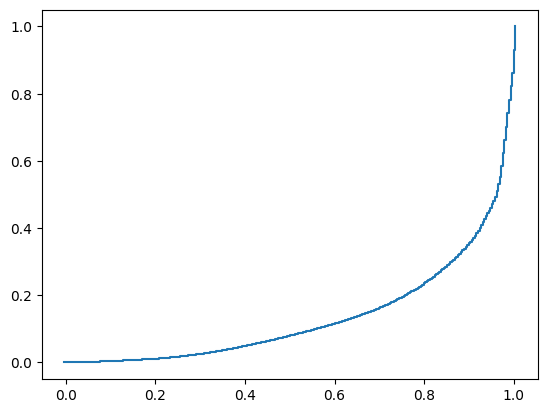

In [22]:
depenses = data[data['montant'] < 0]
dep = -depenses['montant'].values
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz)
xaxis = np.linspace(0-1/n,1+1/n,n+1)
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.show()

# Diagramme de dispersion

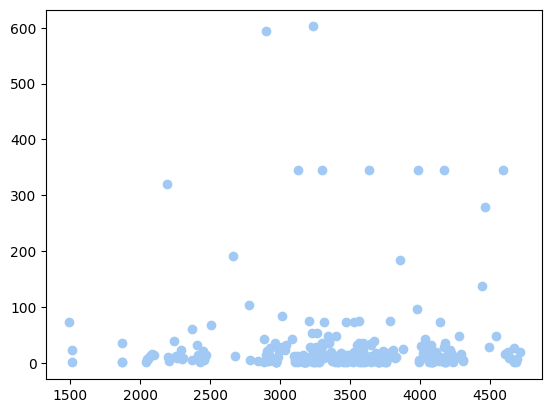

In [23]:
sns.set_palette('pastel')
plt.plot(depenses['solde_avt_ope'],-depenses['montant'],'o')
plt.show()

In [24]:
taille_tranche = 500
tranches = np.arange(0,max(depenses['solde_avt_ope']),taille_tranche)
print(tranches)
groupes= []

[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


In [25]:
tranches += taille_tranche/2
print(tranches)

[ 250.  750. 1250. 1750. 2250. 2750. 3250. 3750. 4250. 4750.]


In [26]:
indices = np.digitize(depenses['solde_avt_ope'],tranches)
len(indices)

291

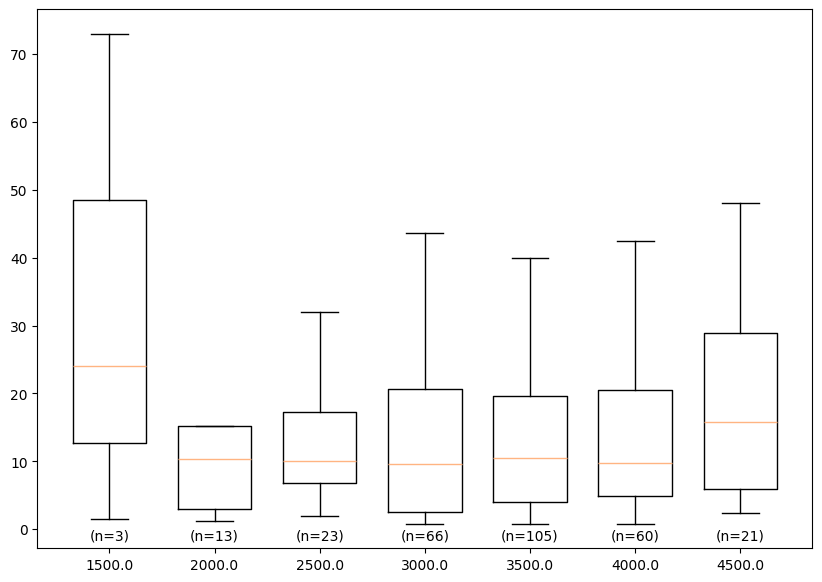

In [27]:
for ind, tr in enumerate(tranches) :
    montants = -depenses.loc[indices==ind,'montant']
    if len(montants) > 0:
        g = {
            'valeurs':montants,
            'centre_classe':tr-(taille_tranche/2),
            'taille':len(montants),
            'quartiles':[np.percentile(montants,p) for p in[25,50,75]]
        }
        groupes.append(g)
plt.figure(figsize=(10,7))
plt.boxplot([g['valeurs'] for g in groupes],
            positions = [g['centre_classe'] for g in groupes],
            showfliers = False,
            widths = taille_tranche *0.7)
for g in groupes:
    plt.text(g['centre_classe'],0,'(n={})'.format(g['taille']),horizontalalignment='center',verticalalignment='top')
plt.show()

In [28]:
print(st.pearsonr(depenses['solde_avt_ope'],-depenses['montant'])[0])
print((np.cov(depenses['solde_avt_ope'],-depenses['montant'])[1,0]))

0.010068819133759201
486.63181582651873


In [29]:
courses = data[data['categ'] == 'COURSES'].copy()
courses['montant'] = -courses['montant']
courses = courses.sort_values('date_operation')
last_date=courses.iloc[0,0]
print(last_date)
att = []
for i,row in courses.iterrows():
    jours = (row['date_operation'] - last_date).days
    last_date = row['date_operation']
    att.append(jours)
print(att)
courses['attente'] = att
courses = courses.iloc[1:,]
a = courses.groupby('date_operation')['montant'].sum()
b = courses.groupby('date_operation')['attente'].first()
courses = pd.DataFrame({'montant':a,'attente':b})
print(courses)

2023-04-05 00:00:00
[0, 5, 15, 1, 2, 4, 2, 1, 5, 5, 0, 8, 6, 2, 12, 0, 0, 0, 4, 3, 0, 7, 0, 2, 15, 12, 6, 0, 7, 10, 5, 6, 3, 4, 7, 7, 2, 6, 0]
                montant  attente
date_operation                  
2023-04-10        42.42        5
2023-04-25        32.67       15
2023-04-26         1.90        1
2023-04-28         9.11        2
2023-05-02        12.24        4
2023-05-04        17.16        2
2023-05-05         3.48        1
2023-05-10        42.45        5
2023-05-15        46.51        5
2023-05-23         4.41        8
2023-05-29        22.59        6
2023-05-31         6.89        2
2023-06-12        39.60       12
2023-06-16         4.39        4
2023-06-19        27.76        3
2023-06-26        34.28        7
2023-06-28        12.49        2
2023-07-13         9.88       15
2023-07-25        60.16       12
2023-07-31        24.37        6
2023-08-07        21.73        7
2023-08-17        28.11       10
2023-08-22        10.91        5
2023-08-28        29.18        6

<Axes: xlabel='attente', ylabel='montant'>

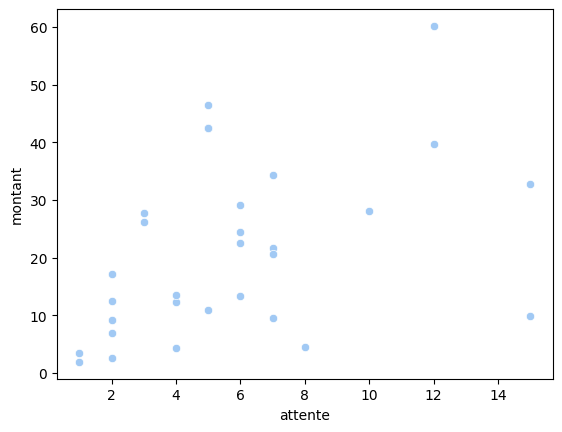

In [30]:
sns.scatterplot(data=courses,x='attente',y='montant')

In [31]:
Y = courses['montant']
X = courses[['attente']]
X['intercept'] = 1
result = sm.OLS(Y,X).fit()
a,b = result.params['attente'],result.params['intercept']

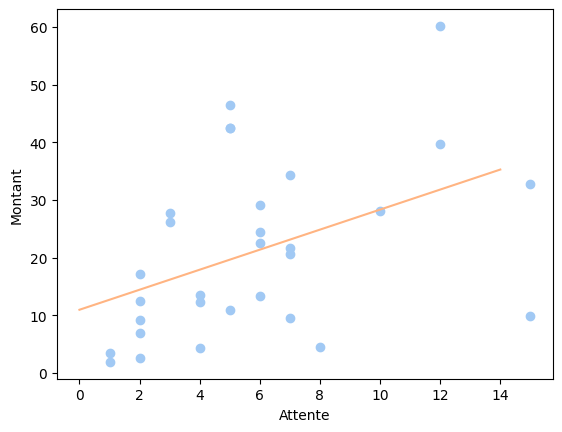

In [32]:
plt.plot(courses.attente,courses.montant,'o')
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel('Attente')
plt.ylabel('Montant')
plt.show()

In [33]:
X ='categ'
Y='montant'
ss_echant = data[data['montant'] < 0].copy()
ss_echant['montant'] = -ss_echant['montant']
ss_echant = ss_echant[ss_echant['categ'] != 'LOYER']

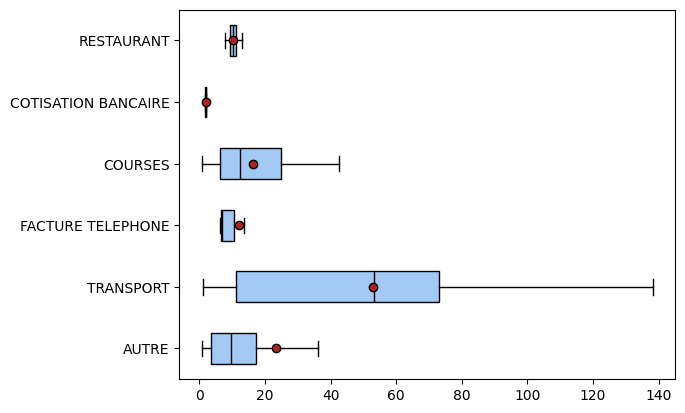

In [34]:
modalites = ss_echant[X].unique()
groupes = []
for m in modalites:
    groupes.append(ss_echant[ss_echant[X] == m][Y])
medianprops = {'color':'black'}
meanprops = {'marker':'o','markeredgecolor':'black','markerfacecolor':'firebrick'}
plt.boxplot(groupes, tick_labels=modalites, showfliers=False, medianprops = medianprops, vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [35]:
sous_echant = data[data['montant'] < 0].copy()
sous_echant['montant'] = -sous_echant['montant']
moyenne = sous_echant.montant.mean()
print(moyenne)
SCE = 0
SCT = 0
categ_moy = []
for m in modalites : 
    list_val = sous_echant[sous_echant['categ']==m]['montant']
    moy = list_val.mean()
    for i,val in enumerate(list_val) :
        SCT = SCT + (val - moyenne)**2
    SCE = SCE + len(list_val)*(moy-moyenne)**2
print(SCE/SCT)

29.719690721649485
0.039729824137878934


categ            AUTRE  COTISATION BANCAIRE    COURSES  FACTURE TELEPHONE  \
quart_mois                                                                  
1            59.194805             1.954545  10.889610           1.954545   
2            52.311688             1.727273   9.623377           1.727273   
3            51.623377             1.704545   9.496753           1.704545   
4            48.870130             1.613636   8.990260           1.613636   
Total       212.000000             7.000000  39.000000           7.000000   

categ          LOYER  RESTAURANT  TRANSPORT  Total  
quart_mois                                          
1           1.675325    4.467532   5.863636   86.0  
2           1.480519    3.948052   5.181818   76.0  
3           1.461039    3.896104   5.113636   75.0  
4           1.383117    3.688312   4.840909   71.0  
Total       6.000000   16.000000  21.000000  308.0  


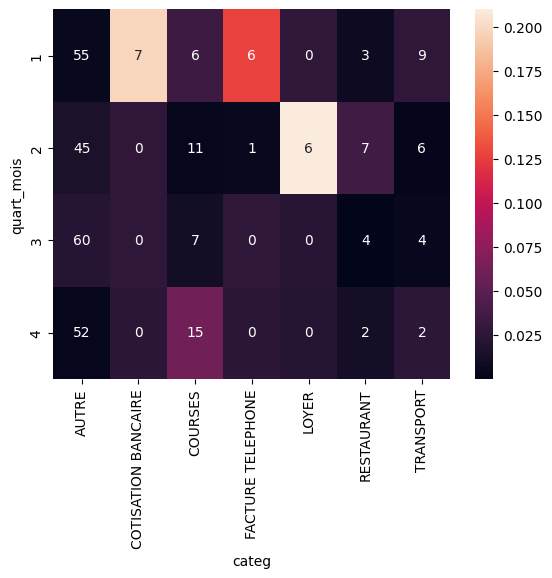

In [36]:
X = "quart_mois"
Y = "categ"

cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")


tx = cont.loc[:,["Total"]]

ty = cont.loc[["Total"],:]

n = len(data)
indep = tx.dot(ty) / n
print(indep)
c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()